In [54]:
import os
import sys

sys.path.append('/home/julien/Bureau/Julien/02_DATA_PROJECTS/Maintenance')

import config

import pandas as pd
import numpy as np


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from imblearn.over_sampling import SMOTENC

from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

from src.utils.Functions import get_metrics # fonction pour avoir les metrics de mon modeling

## EXPLORATION

In [55]:

df = pd.read_csv(os.path.join(config.DATA_DIR, 'maintenance_data.csv'))
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


ID : identifiant  
product ID : Low Medium et High quality products  
air temperature  
Temperature d'activité  
Vitesse adtivité  
torque : force de rotation  
tool wear : usure  
Machone et failure et problemes : TWF= tool failure, HDF = heat dissipation, PWF = power failure, OSF = overstain failure, RNF = random failures  

In [56]:
#check duplicates
df_duplicates = df.duplicated().sum()
df_duplicates

0

In [57]:
#check valeurs manquantes
df_isna = df.isna().sum()
df_isna

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [59]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [60]:
df[df['Machine failure'] == 1]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
69,70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
160,161,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0
161,162,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9759,L56938,L,298.6,309.8,2271,16.2,218,1,1,0,0,0,0
9764,9765,L56944,L,298.5,309.5,1294,66.7,12,1,0,0,1,0,0
9822,9823,L57002,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
9830,9831,L57010,L,298.3,309.3,1337,56.1,206,1,0,0,0,1,0


In [61]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [62]:
#rename

rename_col = {
    'UID' : 'ID',
    'Product ID' : 'Product_ID',
    'Air temperature [K]' : 'Air_Temperature',
    'Process Temperature [K]' : 'Process_Temperature',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_Wear',
    'Machine failure' : 'Failure'
}

df.rename(rename_col, axis=1, inplace=True)



In [63]:
df

,UDI,Product_ID,Type,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [64]:
df.set_index('UDI', inplace=True)

In [65]:
df

,Product_ID,Type,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0


In [66]:
failures_sum = df.Failure.value_counts()
print('il y a',failures_sum[1], 'problemes')



il y a 339 problemes


In [67]:
df.describe()

,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [68]:
# defintion de fonction pour avoir une colonne Failure_type en fonction des valeurs du dataset

def failure_type(row):
    if row['Failure'] == 0:
        return 'No_failure'
    else:
        max_value = max(row[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']])
        if max_value == row['TWF']:
            return 'TWF'
        elif max_value == row['HDF']:
            return 'HDF'
        elif max_value == row['PWF']:
            return 'PWF'
        elif max_value == row['OSF']:
            return 'OSF'
        else:
            return 'RNF'
        
df['Failure_type'] = df.apply(failure_type, axis=1)

df

,Product_ID,Type,Air_Temperature,Process temperature [K],Rotational speed [rpm],Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,No_failure


In [69]:
import pandas as pd

# Define the dictionary mapping old column names to new column names
dic_rename = {
    'Process temperature [K]': 'Process_temperature',
    'Rotational speed [rpm]': 'Rotational_speed'
}

# Assuming df is your DataFrame
df.rename(columns=dic_rename, inplace=True)




In [70]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [71]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,No_failure


## DATAVIZ

In [72]:
# Distribution des classes
count_quality = df['Type'].value_counts()
fig = px.bar(x=count_quality.index, y=count_quality.values, color=count_quality.index)
fig.update_layout(title='Distribution des classes', xaxis_title='Type', yaxis_title='Nombre')
fig.show()


#### beaucoup de materiel qualifié de low  
#### Mauvaise distrib des classes  

In [73]:
import plotly.express as px

# Types de problemes
count_failures = df['Failure_type'].value_counts()

# Calculer les pourcentages
pourcentages = count_failures / count_failures.sum() * 100

# Créer le graphique à barres avec Plotly Express
fig = px.bar(x=count_failures.index, y=count_failures.values, color=count_failures.index, text=pourcentages.round(2).astype(str) + '%')

# Mettre à jour les paramètres de la figure
fig.update_layout(title='Types de problèmes', xaxis_title='Type', yaxis_title='Occurences')

# Afficher les pourcentages au-dessus des barres
fig.update_traces(textposition='outside')

# Afficher la figure
fig.show()


#### forte présence de no failures, ensuite la distribution est plutot equivalente

### Conclusion :
#### mauvaise distribution des classes + multi labels

In [74]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,No_failure


In [75]:

df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)

plt.figure(figsize=(5, 8))
fig = px.pie(proportions, values=proportions.values, names=proportions.index, title='Class Distribution')
fig.show()


<Figure size 500x800 with 0 Axes>

In [76]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,No_failure


In [77]:
import plotly.graph_objects as go

numeric_values = df[['Air_Temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_Wear']]
# Calculate correlation matrix
corr = numeric_values.corr()

plt.figure(figsize=(10, 8))

# Create heatmap trace
heatmap_trace = go.Heatmap(z=corr.values,
                           x=corr.columns,
                           y=corr.columns,
                           colorscale='RdBu',
                           zmin=-1, zmax=1)

# Define layout
layout = go.Layout(title='Correlation of Numeric Values',
                   xaxis=dict(title='Features'),
                   yaxis=dict(title='Features'))

# Create figure
fig = go.Figure(data=[heatmap_trace], layout=layout)

# Show figure
fig.show()



<Figure size 1000x800 with 0 Axes>

#### Air_temp - Process_temp  
#### Torque - Rotational_speed negative corr

## CLEANNING  
ajustement des valeurs sur l ensemble des colonnes numeriques


In [78]:
df

,Product_ID,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure,TWF,HDF,PWF,OSF,RNF,Failure_type
UDI,,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,No_failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,No_failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,No_failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,No_failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,No_failure
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,No_failure
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,No_failure


In [79]:
columns_to_drop = ['Failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Product_ID']
df.drop(columns=columns_to_drop, inplace=True, axis=1)


In [80]:
df

,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure_type
UDI,,,,,,,
1,M,298.1,308.6,1551,42.8,0,No_failure
2,L,298.2,308.7,1408,46.3,3,No_failure
3,L,298.1,308.5,1498,49.4,5,No_failure
4,L,298.2,308.6,1433,39.5,7,No_failure
5,L,298.2,308.7,1408,40.0,9,No_failure
...,...,...,...,...,...,...,...
9996,M,298.8,308.4,1604,29.5,14,No_failure
9997,H,298.9,308.4,1632,31.8,17,No_failure
9998,M,299.0,308.6,1645,33.4,22,No_failure


In [81]:
# Pipeline

#Definition des col num et cat
num_col = ['Air_Temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_Wear']
cat_col = ['Type', 'Failure_type']

# Standard scale pour numeric et one hot pour categories
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, num_col),
    ('cat_trans', cat_pipeline, cat_col)
])
# Entrainement sur les data preprocessor
df_transformed = preprocessor.fit_transform(df)


# Nouveau noms pour les colonnes one hot
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(cat_col)
new_column_names = list(num_col) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Type_H,Type_L,Type_M,Failure_type_HDF,Failure_type_No_failure,Failure_type_OSF,Failure_type_PWF,Failure_type_TWF
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


##

## DIM_REDUCTION

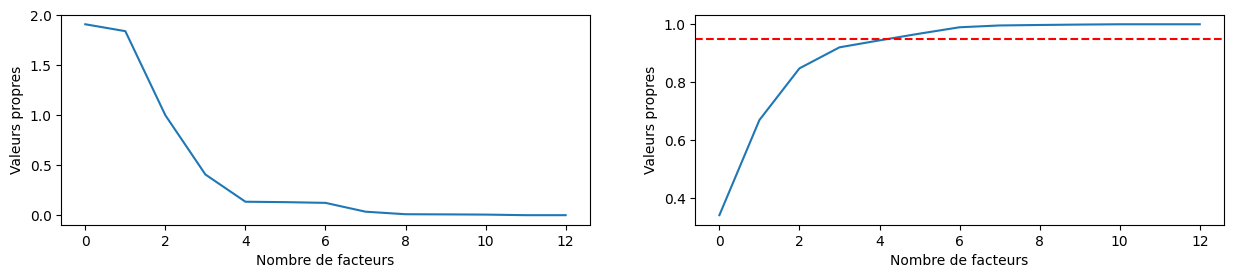

In [82]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_transformed)

plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.plot(range(0,13), pca.explained_variance_)
plt.xlabel('Nombre de facteurs')
plt.ylabel('Valeurs propres')

plt.subplot(2,2,2)
plt.plot(range(0,13), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de facteurs')
plt.ylabel('Valeurs propres')
plt.axhline(y=0.95, color = 'r', linestyle = '--')

In [83]:
pca = PCA(n_components=0.95)
pca.fit(df_transformed)
print('number of usefull component', pca.n_components_)

number of usefull component 6


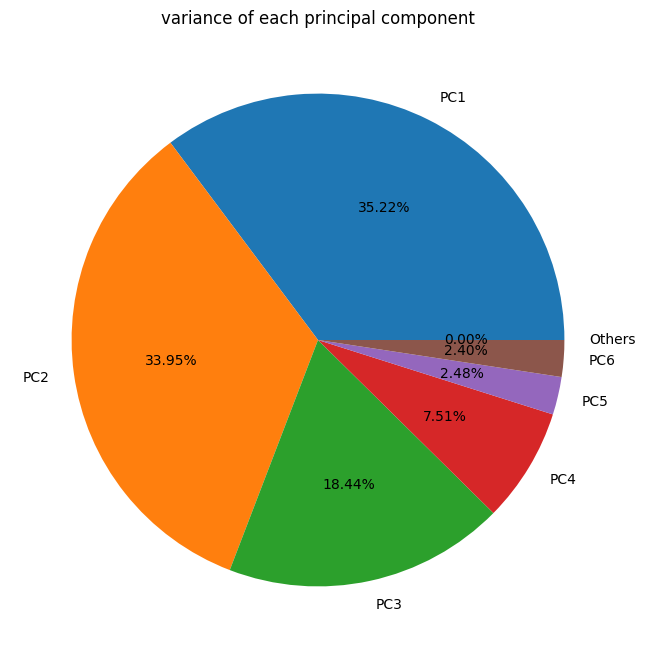

In [84]:
L1 = list(pca.explained_variance_ratio_[0:7])
L1.append(sum(pca.explained_variance_ratio_[7:14]))

plt.figure(figsize=(10, 8))
plt.pie(L1, labels=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'Others'], 
        autopct='%1.2f%%')

plt.title("variance of each principal component")
plt.show()

In [85]:
df_transformed

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Type_H,Type_L,Type_M,Failure_type_HDF,Failure_type_No_failure,Failure_type_OSF,Failure_type_PWF,Failure_type_TWF
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.602417,-1.082162,0.363820,-1.052012,-1.476034,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9996,-0.552421,-1.082162,0.520005,-0.821283,-1.428902,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9997,-0.502425,-0.947360,0.592519,-0.660777,-1.350349,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9998,-0.502425,-0.879959,-0.729472,0.854005,-1.303217,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [86]:
df_modeling = df.copy()

In [87]:
df_modeling

,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure_type
UDI,,,,,,,
1,M,298.1,308.6,1551,42.8,0,No_failure
2,L,298.2,308.7,1408,46.3,3,No_failure
3,L,298.1,308.5,1498,49.4,5,No_failure
4,L,298.2,308.6,1433,39.5,7,No_failure
5,L,298.2,308.7,1408,40.0,9,No_failure
...,...,...,...,...,...,...,...
9996,M,298.8,308.4,1604,29.5,14,No_failure
9997,H,298.9,308.4,1632,31.8,17,No_failure
9998,M,299.0,308.6,1645,33.4,22,No_failure


## TRAIN TEST SPLIT

In [88]:
X = df_modeling[num_col+ cat_col]
y = df_modeling['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

## MODELING

In [117]:
# Creating pipeline with PCA analysis and balanced class and Random Forest
pip_model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=7)),
    ('model', RandomForestClassifier(n_estimators= 100, criterion='gini', min_samples_leaf=2, min_samples_split=5, max_depth=10, class_weight='balanced', random_state=2023))
])

# Fit pipeline with PCA
#weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_rf.fit(X_train, y_train) #model__sample_weight=weights)

# Generate Predictions using the correctly fitted pipeline
y_pred = pip_model_rf.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

{'Accuracy': 0.9785,
 'Recall': 0.8055461446765794,
 'Precision': 0.7317492586008946,
 'F1': 0.762289016336326,
 'F1 Scores per Class': array([0.7037037 , 0.98882246, 1.        , 0.91891892, 0.2       ])}

In [119]:
# Creating pipeline with PCA analysis and balanced class and GBC
pip_model_no_gbc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('model', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10,
                                           min_samples_split=2, min_samples_leaf=1,
                                           subsample=1.0, random_state=2023))
])

# Fit pipeline with sample weights
#weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_gbc.fit(X_train, y_train) #model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_gbc.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.982,
 'Recall': 0.6560010038270907,
 'Precision': 0.7490877192982456,
 'F1': 0.6730499129069453,
 'F1 Scores per Class': array([0.4375    , 0.99124163, 0.91428571, 0.88888889, 0.13333333])}

In [99]:
# Creating pipeline with PCA analysis and balanced class and SVC
pip_model_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('model', SVC(kernel='rbf', C=1.0, gamma='scale',class_weight='balanced', random_state=2023))
])

# Fit pipeline with sample weights
#weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_svc.fit(X_train, y_train) #model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_svc.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.82,
 'Recall': 0.7910322165756948,
 'Precision': 0.4472623447081321,
 'F1': 0.49682152192738177,
 'F1 Scores per Class': array([0.19354839, 0.900369  , 0.63829787, 0.68292683, 0.06896552])}

In [92]:
# Creating pipeline with PCA analysis and balanced class and LGBMC
pip_model_lgbmc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('model', LGBMClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_lgbmc.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_lgbmc.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

{'Accuracy': 0.987,
 'Recall': 0.7399146746972833,
 'Precision': 0.8128988493903486,
 'F1': 0.7669709521557684,
 'F1 Scores per Class': array([0.69767442, 0.99457785, 0.94117647, 0.84848485, 0.35294118])}

In [93]:
# Creating pipeline with PCA analysis and balanced class and Ada Boost
pip_model_ada = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('model', AdaBoostClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_ada.fit(X_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_ada.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

/home/julien/anaconda3/envs/maintenance_env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



{'Accuracy': 0.901,
 'Recall': 0.5571107033063554,
 'Precision': 0.5092107901932701,
 'F1': 0.5081480672250462,
 'F1 Scores per Class': array([0.17977528, 0.94928897, 0.6       , 0.77777778, 0.03389831])}

In [121]:
# New parameters for fine-tuning the rf
fine_tune_params = {
    
    'model__n_estimators': [50, 100, 300, 500],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Running a new GridSearchCV for fine-tuning
fine_tune_grid = GridSearchCV(pip_model_rf, fine_tune_params, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
fine_tune_grid.fit(X_train, y_train)

# Collecting and printing the fine-tuned results
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, 'params']

# Print best model parameters
print("Best fine-tuned model parameters:")
print(fine_tuned_best_params)

# Finding the best estimator paramaters
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(X_test)

# View new perfomance (focus on F1-score)
get_metrics(y_test, y_pred)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best fine-tuned model parameters:
{'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500}


{'Accuracy': 0.979,
 'Recall': 0.7765637743898612,
 'Precision': 0.7307791723011043,
 'F1': 0.750322367144797,
 'F1 Scores per Class': array([0.73076923, 0.98909657, 1.        , 0.88888889, 0.14285714])}

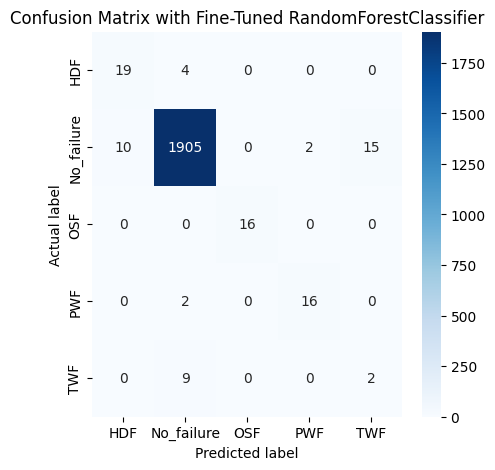

In [122]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))  # Larger figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Use 'd' to format numbers as integers
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_pred))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned RandomForestClassifier')
plt.show()